# 4.2.2 Capstone Analytic Report and Research Proposal

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import ttest_ind
%matplotlib inline



## Data Set Description
by: Salil Ketkar

#### Data Source: https://data.lacounty.gov/Health/LOS-ANGELES-COUNTY-RESTAURANT-AND-MARKET-INSPECTIO/6ni6-h5kp

#### Context:  

The dataset contains data from restaurant and market health evaluations from the county of Los Angeles.  All inspections were performed in 2015 to 2018.  Data will be analzyed and visualized to answer the following questions:

1. Does the risk given to each restaurant accurately represent the score received?
2. How do grades/scores vary across zipcodes? How do zip codes rank in terms of average scores? 
3. How do the scores of chain restaurants compare to score of local spots?  For example, chipotle mexican grill v. local mexican restaurants.  



#### Abbreviations and Scales: 
serial_number - unique ID for each inspection (string) activity_date - date of inspection (date: yyyy/mm/dd format) facility_name - name of facility (string) score - the score of the inpsection (integer 0 to 100) grade - the grade of the inspection (string A to F) service_code - identifies the service performed (string) service description - describes the service that was performed (string) employee_ID - id number of the employee who performed the inspection (string) facility_address - address of the facility (string) facility_city - address of the facility (string) 
facility_ID - represents a specific facility record (string) facility_state - state of the facility (string) facility_zip - zip code of the facility (integer) owner_id - represents a specific owner record (string) owner_name - name of the legal owner (string) pe_description - describes the type of program (string) program_element_pe - the code identifies the type of program (string) program_name - A unique name for each program. There may be more than one program at a facility (string) program_status - indicates the status of the program (string) record_id - 	
Unique ID number for each health program at a facility



In [234]:
#upload csv containing data set provided by LA county

la_inspections = pd.read_csv('/Users/salilketkar/thinkful/LA_health_score_inspections.csv')

In [235]:
#formatting data
la_inspections['facility_city'] = la_inspections['facility_city'].str.title()
la_inspections['pe_description'] = la_inspections['pe_description'].str.title()

#shorten zip code to be 5 numbers and date follow yyyy-mm-dd format
la_inspections['facility_zip_short'] = la_inspections['facility_zip'].apply(lambda x: x[:5])
la_inspections['activity_date_short'] = la_inspections['activity_date'].apply(lambda x: x[:10])
la_inspections['facility_name_new'] = la_inspections['facility_name'].apply(lambda x: x.replace("'",""))
la_inspections['facility_name_new'] = la_inspections['facility_name_new'].str.title()

#creating new dataset with relevant columns
la_inspections_new = la_inspections[['activity_date_short','facility_name_new','score','grade','facility_city','facility_state',
                                     'facility_zip_short','pe_description','facility_id']]
la_inspections_new.head()

,activity_date_short,facility_name_new,score,grade,facility_city,facility_state,facility_zip_short,pe_description,facility_id
0,2017-12-29,Habitat Coffee Shop,95,A,Los Angeles,CA,90065,Restaurant (0-30) Seats Moderate Risk,FA0170465
1,2017-12-29,Reillys,92,A,Los Angeles,CA,90045,Restaurant (0-30) Seats Moderate Risk,FA0244690
2,2017-12-29,Street Churros,93,A,Los Angeles,CA,90028,Restaurant (0-30) Seats Low Risk,FA0224109
3,2017-12-29,Rio Gentlemans Club,93,A,Los Angeles,CA,90064,Restaurant (61-150) Seats Low Risk,FA0046462
4,2017-12-29,Le Pain Quotidien,93,A,Los Angeles,CA,90049,Restaurant (61-150) Seats High Risk,FA0034788


In [236]:
la_inspections['score'].describe()

count    58872.000000
mean        93.307922
std          3.996712
min         64.000000
25%         91.000000
50%         94.000000
75%         96.000000
max        100.000000
Name: score, dtype: float64

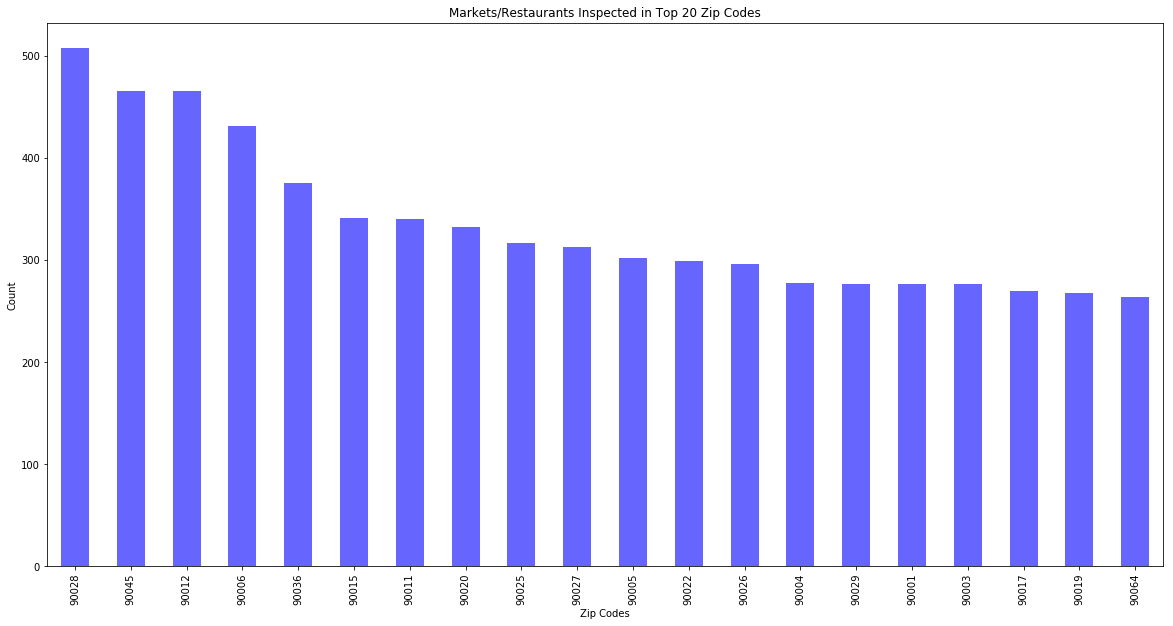

In [237]:
#create bar graph to show what zipcodes have the most restaurants that were inspected.  No duplicates
la_inspections_facilityID = la_inspections_new.groupby(['facility_id', 'facility_zip_short']).size().reset_index(name='Freq')

#Create a pnd series of zip code sorted by number of facility_id (Freq)
Freq=la_inspections_facilityID.groupby('facility_zip_short').count()['Freq'].sort_values(axis=0, ascending=False)

plt.figure(figsize=(20, 10))
Freq.nlargest(20).plot(kind='bar',color='blue',title='Markets/Restaurants Inspected in Top 20 Zip Codes', alpha=0.6)
plt.xlabel('Zip Codes')
plt.ylabel('Count')
plt.show()

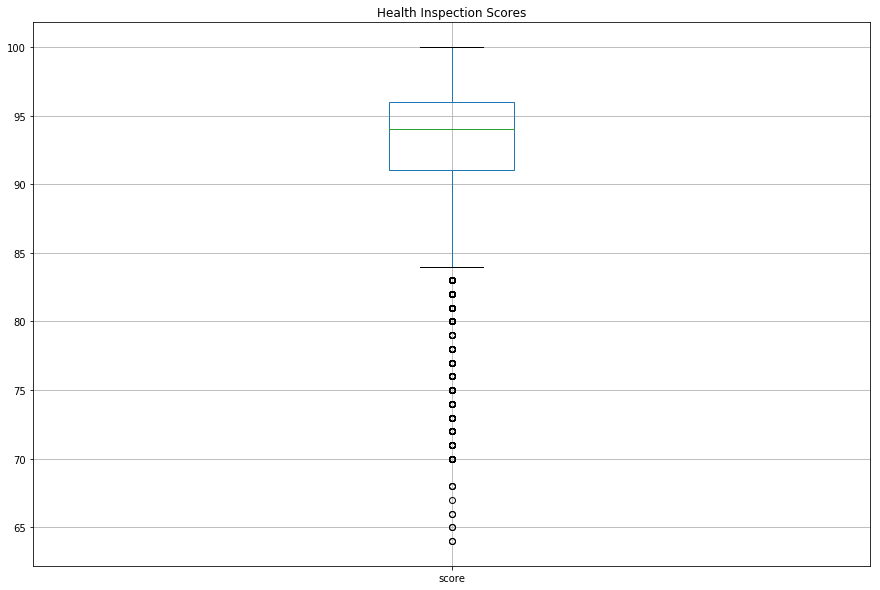

In [238]:
#created boxplot to determine where values lie
plt.figure(figsize=(15, 10))
la_inspections_new.boxplot('score')
plt.title("Health Inspection Scores")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

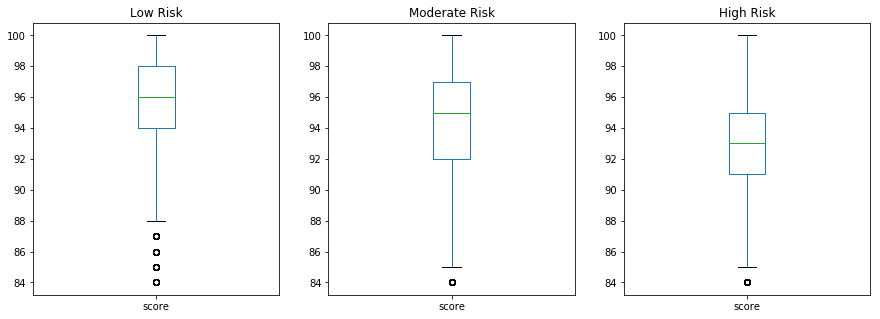

In [244]:
'''creating boxplots for scores of restarurants that were classified as low, medium, and high risk to determine if 
there is any significant change in the scores.
'''

la_inspections_new['pe_description_mod']=la_inspections_new['pe_description'].apply(lambda x: x.find('Moderate Risk')>0)
la2 = la_inspections_new[(la_inspections_new['pe_description_mod'] == True)]
la2= la2[(la2['score']>=84)]
la2.sort_values('score',ascending=True).head()

la_inspections_new['pe_description_high']=la_inspections_new['pe_description'].apply(lambda x: x.find('High Risk')>0)
la3 = la_inspections_new[(la_inspections_new['pe_description_high'] == True)]
la3= la3[(la3['score']>=84)]
la3.sort_values('score',ascending=True).head()

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(1,3,1)
la1['score'].plot(kind='box',title='Low Risk')


fig.add_subplot(1,3,2)
la2['score'].plot(kind='box',title='Moderate Risk')


fig.add_subplot(1,3,3)
la3['score'].plot(kind='box',title='High Risk')
plt.show()


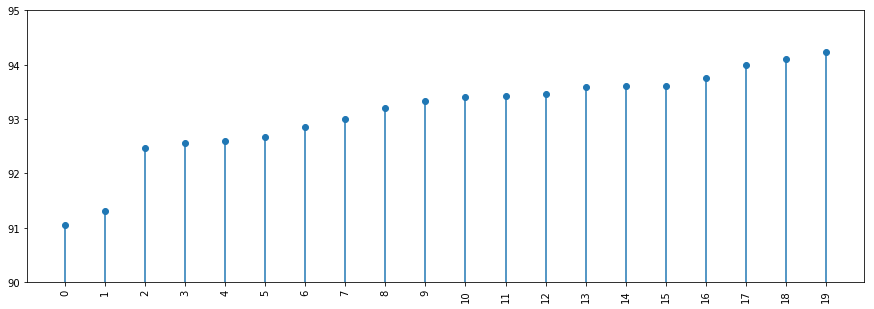

In [243]:
#create bar graph to show what zipcodes have the most restaurants that were inspected.  No duplicates
la_inspections_facilityID = la_inspections_new.groupby(['facility_id', 'facility_zip_short']).size().reset_index(name='Freq')

#Create a pnd series of zip code sorted by number of facility_id (Freq)
Freq=la_inspections_facilityID.groupby('facility_zip_short').count()['Freq'].sort_values(axis=0, ascending=False)

#ranking zipcodes based on average score
df_rank=la_inspections_new.groupby('facility_zip_short')['score'].agg(['mean'])
rank = df_rank.join(Freq)
rank = rank.nlargest(20,'Freq').sort_values('mean',ascending=True)

plt.figure(figsize=(15, 5))
plt.stem(rank['mean'])
plt.ylim(90,95)
plt.xticks(np.arange(20),rotation='vertical')
plt.show()

In [258]:
#comparing local restaurants to chain 
#local mexican restaurants

la_inspections_new['local']=la_inspections_new['facility_name_new'].apply(lambda x: x.find('Taco' or 'Mexican')>0)
localMex = la_inspections_new[(la_inspections_new['local'] == True)]
localMex= localMex[(localMex['score']>=84)]
#localMex.sort_values('score',ascending=False).head()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [290]:
la_inspections_new['chain']=la_inspections_new['facility_name_new'].apply(lambda x: x.find('Chipotle')>0)                                                                                                      
chainMex = la_inspections_new[(la_inspections_new['chain'] == True)]
chainMex = chainMex[(chainMex['score']>=84)]
chainMex.sort_values('score',ascending=True).head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,activity_date_short,facility_name_new,score,grade,facility_city,facility_state,facility_zip_short,pe_description,facility_id,pe_description_low,pe_description_mod,pe_description_high,local,chain
